# Lesson 3: Tune an LLM with RLHF

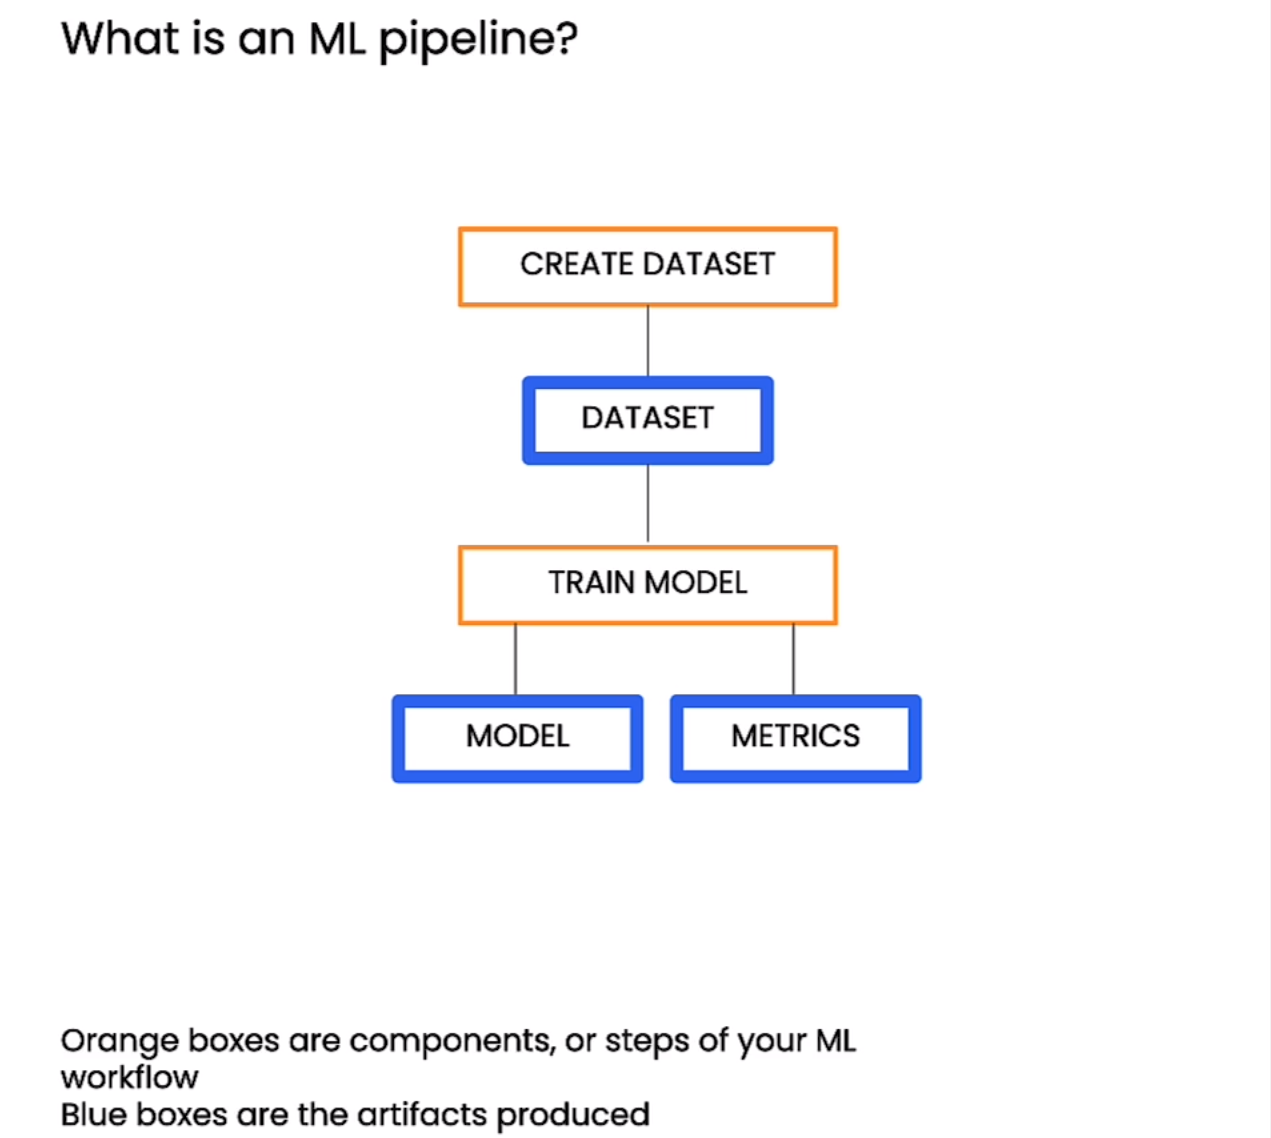

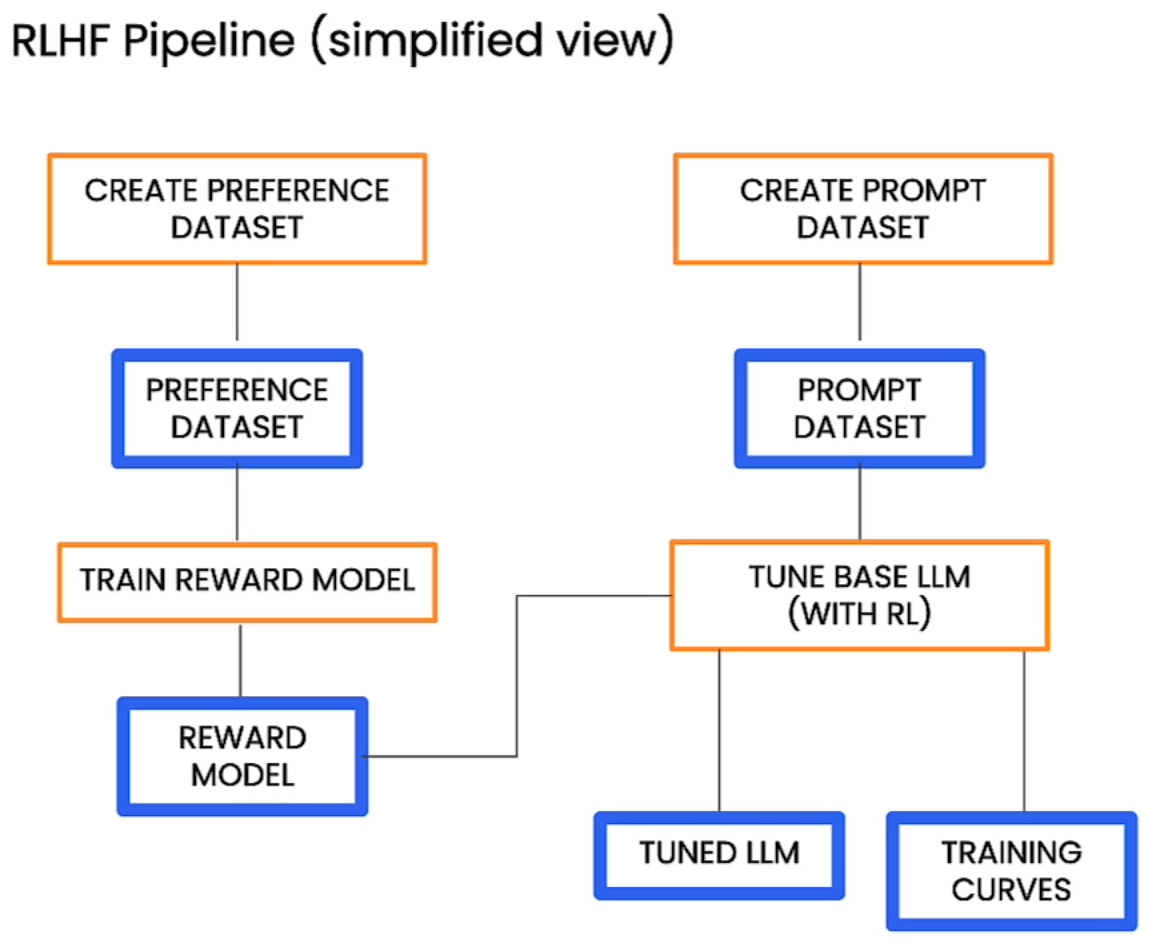

#### Project environment setup

The RLHF training process has been implemented in a machine learning pipeline as part of the (Google Cloud Pipeline Components) library. This can be run on any platform that supports KubeFlow Pipelines (an open source framework), and can also run on Google Cloud's Vertex AI Pipelines.

To run it locally, install the following:

```Python
!pip3 install google-cloud-pipeline-components
!pip3 install kfp
```

### Compile the pipeline

In [1]:
# Import (RLFH is currently in preview)
from google_cloud_pipeline_components.preview.llm \
import rlhf_pipeline

In [2]:
# Import from KubeFlow pipelines
from kfp import compiler

In [3]:
# Define a path to the yaml file
RLHF_PIPELINE_PKG_PATH = "rlhf_pipeline.yaml"

In [4]:
# Execute the compile function
compiler.Compiler().compile(
    pipeline_func=rlhf_pipeline,
    package_path=RLHF_PIPELINE_PKG_PATH
)

In [5]:
# Print the first lines of the YAML file
!head rlhf_pipeline.yaml

# PIPELINE DEFINITION
# Name: rlhf-train-template
# Description: Performs reinforcement learning from human feedback.
# Inputs:
#    deploy_model: bool [Default: True]
#    eval_dataset: str
#    instruction: str
#    kl_coeff: float [Default: 0.1]
#    large_model_reference: str
#    location: str [Default: '{{$.pipeline_google_cloud_location}}']


- Has everything we need to create a pipeline

**Note**: to print the whole YAML file, use the following:
```Python
!cat rlhf_pipeline.yaml
```

## Define the Vertex AI pipeline job

### Define the location of the training and evaluation data
Previously, the datasets were loaded from small JSONL files, but for typical training jobs, the datasets are much larger, and are usually stored in cloud storage (in this case, Google Cloud Storage).

**Note:** Make sure that the three datasets are stored in the same Google Cloud Storage bucket.
```Python
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
    ...
```

### Choose the foundation model to be tuned

In this case, we are tuning the [Llama-2](https://ai.meta.com/llama/) foundational model, the LLM to tune is called **large_model_reference**. 

In this course, we're tuning the llama-2-7b, but you can also run an RLHF pipeline on Vertex AI to tune models such as: the T5x or text-bison@001. 

```Python
parameter_values={
        "large_model_reference": "llama-2-7b",
        ...
```

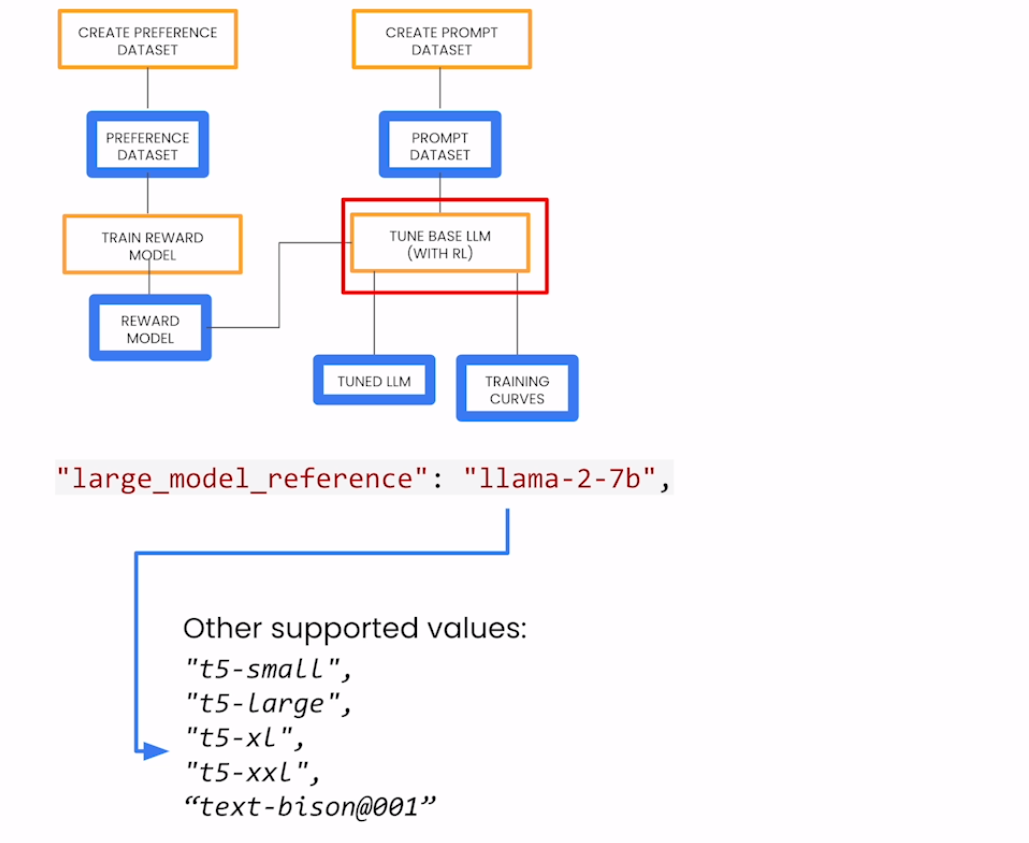

### Calculate the number of reward model training steps

**reward_model_train_steps** is the number of steps to use when training the reward model.  This depends on the size of your preference dataset. We recommend the model should train over the preference dataset for 20-30 epochs for best results.

$$ stepsPerEpoch = \left\lceil \frac{datasetSize}{batchSize} \right\rceil$$
$$ trainSteps = stepsPerEpoch \times numEpochs$$

The RLHF pipeline parameters are asking for the number of training steps and not number of epochs. Here's an example of how to go from epochs to training steps, given that the batch size for this pipeline is fixed at 64 examples per batch.



In [7]:
# Preference dataset size
PREF_DATASET_SIZE = 3000

In [8]:
# Batch size is fixed at 64
BATCH_SIZE = 64

In [9]:
import math

In [10]:
REWARD_STEPS_PER_EPOCH = math.ceil(PREF_DATASET_SIZE / BATCH_SIZE)
print(REWARD_STEPS_PER_EPOCH)

47


In [11]:
REWARD_NUM_EPOCHS = 30

In [12]:
# Calculate number of steps in the reward model training
reward_model_train_steps = REWARD_STEPS_PER_EPOCH * REWARD_NUM_EPOCHS

In [13]:
print(reward_model_train_steps)

1410


### Calculate the number of reinforcement learning training steps
The **reinforcement_learning_train_steps** parameter is the number of reinforcement learning steps to perform when tuning the base model. 
- The number of training steps depends on the size of your prompt dataset. Usually, this model should train over the prompt dataset for roughly 10-20 epochs.
- Reward hacking: if given too many training steps, the policy model may figure out a way to exploit the reward and exhibit undesired behavior.

In [14]:
# Prompt dataset size
PROMPT_DATASET_SIZE = 2000

In [15]:
# Batch size is fixed at 64
BATCH_SIZE = 64

In [16]:
import math

In [17]:
RL_STEPS_PER_EPOCH = math.ceil(PROMPT_DATASET_SIZE / BATCH_SIZE)
print(RL_STEPS_PER_EPOCH)

32


In [18]:
RL_NUM_EPOCHS = 10

In [19]:
# Calculate the number of steps in the RL training
reinforcement_learning_train_steps = RL_STEPS_PER_EPOCH * RL_NUM_EPOCHS

In [20]:
print(reinforcement_learning_train_steps)

320


### Define the instruction

- Choose the task-specific instruction that you want to use to tune the foundational model.  For this example, the instruction is "Summarize in less than 50 words."
- You can choose different instructions, for example, "Write a reply to the following question or comment." Note that you would also need to collect your preference dataset with the same instruction added to the prompt, so that both the responses and the human preferences are based on that instruction.

In [21]:
# Completed values for the dictionary
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b",
        "reward_model_train_steps": 1410,
        "reinforcement_learning_train_steps": 320, # results from the calculations above
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 1.0,
        "kl_coeff": 0.1, # increased to reduce reward hacking
        "instruction":\
    "Summarize in less than 50 words"}

### Train with full dataset: dictionary 'parameter_values' 

- Adjust the settings for training with the full dataset to achieve optimal results in the evaluation (next lesson). Take a look at the new values; these results are from various training experiments in the pipeline, and the best parameter values are displayed here.

```python
parameter_values={
        "preference_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text/reddit_tfds/train/*.jsonl",
        "eval_dataset": \
    "gs://vertex-ai/generative-ai/rlhf/text/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b",
        "reward_model_train_steps": 10000,
        "reinforcement_learning_train_steps": 10000, 
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 0.2,
        "kl_coeff": 0.1,
        "instruction":\
    "Summarize in less than 50 words"}
```

### Set up Google Cloud to run the Vertex AI pipeline

Vertex AI is already installed in this classroom environment.  If you were running this on your own project, you would install Vertex AI SDK like this:
```Python
!pip3 install google-cloud-aiplatform
```

In [22]:
# Authenticate in utils
from utils import authenticate
credentials, PROJECT_ID, STAGING_BUCKET = authenticate()

# RLFH pipeline is available in this region
REGION = "europe-west4"

## Run the pipeline job on Vertex AI

Now that we have created our dictionary of values, we can create a PipelineJob. This just means that the RLHF pipeline will execute on Vertex AI. So it's not running locally here in the notebook, but on some server on Google Cloud.

In [23]:
import google.cloud.aiplatform as aiplatform

In [24]:
aiplatform.init(project = PROJECT_ID,
                location = REGION,
                credentials = credentials)

In [25]:
# Look at the path for the YAML file
RLHF_PIPELINE_PKG_PATH

'rlhf_pipeline.yaml'

### Create and run the pipeline job
- Here is how you would create the pipeline job and run it if you were working on your own project.
- This job takes about a full day to run with multiple accelerators (TPUs/GPUs), and so we're not going to run it in this classroom.

- To create the pipeline job:

```Python
job = aiplatform.PipelineJob(
    display_name="tutorial-rlhf-tuning",
    pipeline_root=STAGING_BUCKET,
    template_path=RLHF_PIPELINE_PKG_PATH,
    parameter_values=parameter_values)
```
- To run the pipeline job:

```Python
job.run()
```

- The content team has run this RLHF training pipeline to tune the Llama-2 model, and in the next lesson, you'll get to evaluate the log data to compare the performance of the tuned model with the original foundational model.